# 3D plot

This notebook contains scripts to visualise 3D surface, arrows, scatter points and lines

In [ ]:
!pip install ipympl

In [1]:

from typing import Tuple
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget



In [51]:
import torch
import matplotlib.pyplot as plt


class View3D:
    """
    Utility class for visualizing 3D geometric objects using Matplotlib.

    This class provides convenience wrappers around common 3D plotting
    primitives such as:
        - surfaces
        - scatter points
        - vector fields (quiver arrows)

    All data is assumed to be in the form of tensors with shape:
        (3, N)        for point clouds / vectors
        (3, H, W)     for surfaces (meshgrids)

    Coordinate convention:
        xyz[0] → x-coordinates
        xyz[1] → y-coordinates
        xyz[2] → z-coordinates
    """

    def __init__(self, xyz, figsize=(10., 10.)):
        """
        Initialize a 3D figure and axes.

        Parameters
        ----------
        xyz : torch.Tensor or np.ndarray
            Tensor containing 3D data, typically of shape (3, H, W)
            for surfaces or (3, N) for point clouds.

        figsize : tuple of float, optional
            Size of the Matplotlib figure in inches.
        """
        self.xyz = xyz

        # Create figure and 3D axis
        self.fig = plt.figure(figsize=figsize)
        self.ax = self.fig.add_subplot(1, 1, 1, projection='3d')

    def surface(self, label='surf'):
        """
        Plot a 3D surface.

        Assumes self.xyz has shape (3, H, W) corresponding to a meshgrid.
        """
        surf = self.ax.plot_surface(
            self.xyz[0, :, :],   # X coordinates
            self.xyz[1, :, :],   # Y coordinates
            self.xyz[2, :, :],   # Z values
            cmap="viridis",
            alpha=0.8,
            linewidth=0
        )

        if label is not None:
            surf._legend_label = label
            self._has_label = True


    def quiver(self, xyz: torch.Tensor, dxdydz: torch.Tensor, normalize: bool = True):
        """
        Plot 3D vectors (quiver plot).

        Parameters
        ----------
        xyz : torch.Tensor
            Starting points of vectors, shape (3, N).

        dxdydz : torch.Tensor
            Vector directions / magnitudes, shape (3, N).

        normalize : bool, optional
            If True, all vectors are normalized to unit length.
            Direction is preserved, magnitude is discarded.
        """
        self.ax.quiver(
            xyz[0, :],  # vector origins (x)
            xyz[1, :],  # vector origins (y)
            xyz[2, :],  # vector origins (z)
            dxdydz[0, :],  # x-component
            dxdydz[1, :],  # y-component
            dxdydz[2, :],  # z-component
            normalize=normalize,
            linewidth=1,
            arrow_length_ratio=0.4
        )

    def scatter(self, xyz: torch.Tensor, z_as_color: bool = True):
        """
        Plot a 3D scatter plot.

        Parameters
        ----------
        xyz : torch.Tensor
            Point coordinates, shape (3, N).

        z_as_color : bool, optional
            If True, use z-values to color points.
        """
        self.ax.scatter(
            xyz[0, :],  # x positions
            xyz[1, :],  # y positions
            xyz[2, :],  # z positions
            c=xyz[2, :] if z_as_color else None,
            s=40,
            alpha=0.8,
            cmap='magma',
            label='scatter'
        )

    def draw_x_direction(self, xyz: torch.Tensor, uvw: torch.Tensor, normalize: bool = True):
        """
        Draw vectors showing only the x-component of a vector field.

        Useful for visualizing directional decomposition.

        Parameters
        ----------
        xyz : torch.Tensor
            Vector origins, shape (3, N).

        uvw : torch.Tensor
            Full vector field, shape (3, N).

        normalize : bool, optional
            Normalize vector lengths.
        """
        self.ax.quiver(
            xyz[0, :],
            xyz[1, :],
            xyz[2, :],
            uvw[0, :],                       # x-component only
            torch.zeros_like(uvw[1, :]),
            torch.zeros_like(uvw[2, :]),
            color='c',
            normalize=normalize
        )

    def draw_y_direction(self, xyz: torch.Tensor, uvw: torch.Tensor, normalize: bool = True):
        """
        Draw vectors showing only the y-component of a vector field.
        """
        self.ax.quiver(
            xyz[0, :],
            xyz[1, :],
            xyz[2, :],
            torch.zeros_like(uvw[0, :]),
            uvw[1, :],                       # y-component only
            torch.zeros_like(uvw[2, :]),
            color='m',
            normalize=normalize
        )

    def draw_z_direction(self, xyz: torch.Tensor, uvw: torch.Tensor, normalize: bool = True):
        """
        Draw vectors showing only the z-component of a vector field.
        """
        self.ax.quiver(
            xyz[0, :],
            xyz[1, :],
            xyz[2, :],
            torch.zeros_like(uvw[0, :]),
            torch.zeros_like(uvw[1, :]),
            uvw[2, :],                       # z-component only
            color='k',
            normalize=normalize
        )

    def set_xlabel(self, label: str):
        """Set x-axis label."""
        self.ax.set_xlabel(label)

    def set_ylabel(self, label: str):
        """Set y-axis label."""
        self.ax.set_ylabel(label)

    def set_zlabel(self, label: str):
        """Set z-axis label."""
        self.ax.set_zlabel(label)

    def set_xlim(self, min_: float, max_: float):
        """Set x-axis limits."""
        self.ax.set_xlim(min_, max_)

    def set_ylim(self, min_: float, max_: float):
        """Set y-axis limits."""
        self.ax.set_ylim(min_, max_)

    def set_zlim(self, min_: float, max_: float):
        """Set z-axis limits."""
        self.ax.set_zlim(min_, max_)
    
    def legend(self, **kwargs):
        """ Show legend if labeled componets exist
        """
        if self._has_label:
            self.ax.legend(**kwargs)

    def show(self):
        """Render the figure."""
        self.legend()
        plt.show()


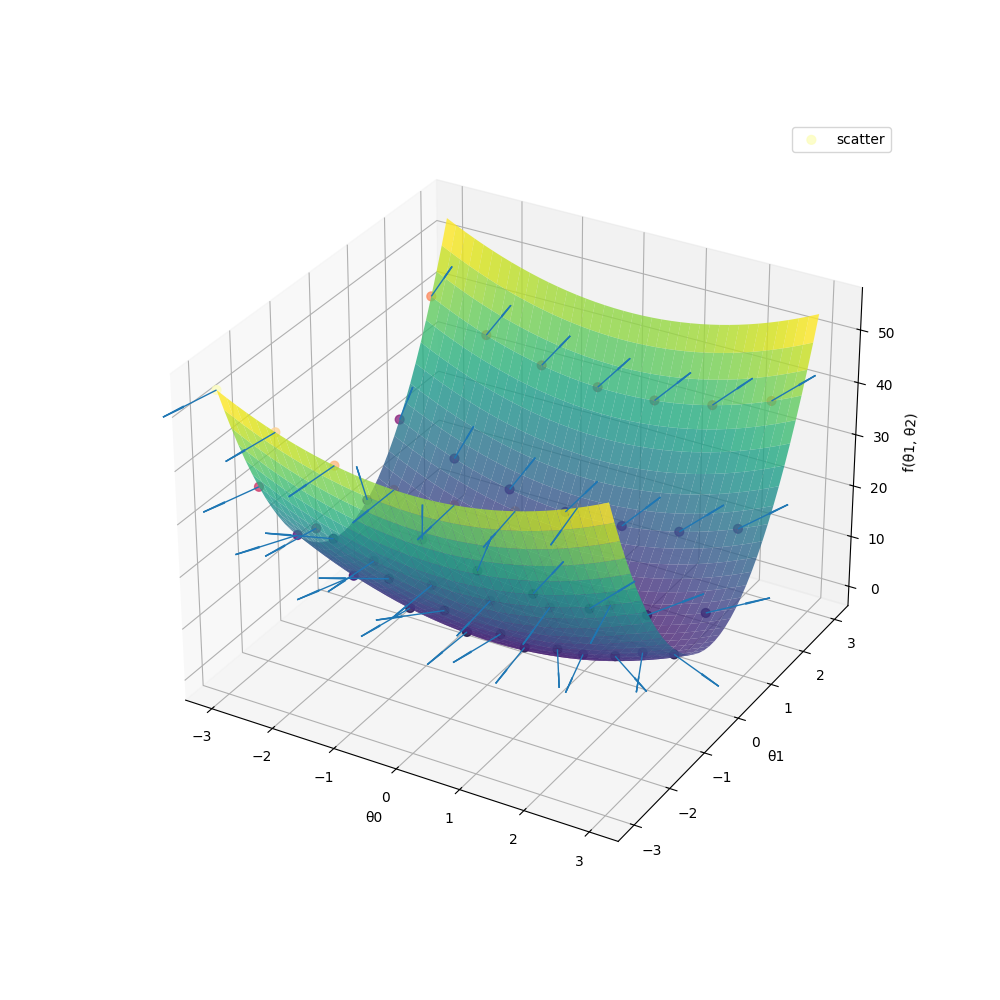

In [52]:

# ----- Enable interactivity -----
plt.ion()

# ----- Grid -----
n = 40
a0 = torch.linspace(-3, 3, n)
a1 = torch.linspace(-3, 3, n)
A0, A1 = torch.meshgrid(a0, a1)
A0.requires_grad = True
A1.requires_grad = True

# ----- Function -----
Z = A0**2 + 5*A1**2

# ----- Gradients -----
Z.sum().backward()
G0 = 2*A0.detach()
G1 = 10*A1.detach()

# ----- Convert -----
A0n = A0.detach()
A1n = A1.detach()
Zn = Z.detach()

step = 6

xyz = torch.stack([A0n, A1n, Zn])
viewer = View3D(xyz=xyz)
viewer.surface()

viewer.scatter(xyz=xyz[:, ::step, ::step], z_as_color=True)

dxdydz = torch.stack([G0, G1, torch.zeros_like(G1)])
viewer.quiver(xyz=xyz[:, ::step, ::step], dxdydz=dxdydz[:, ::step, ::step])

viewer.set_xlabel('θ0')
viewer.set_ylabel('θ1')
viewer.set_zlabel('f(θ1, θ2)')


viewer.show()


In [53]:
xyz.shape

torch.Size([3, 40, 40])

c:\Tools\anaconda3\envs\da-py310\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


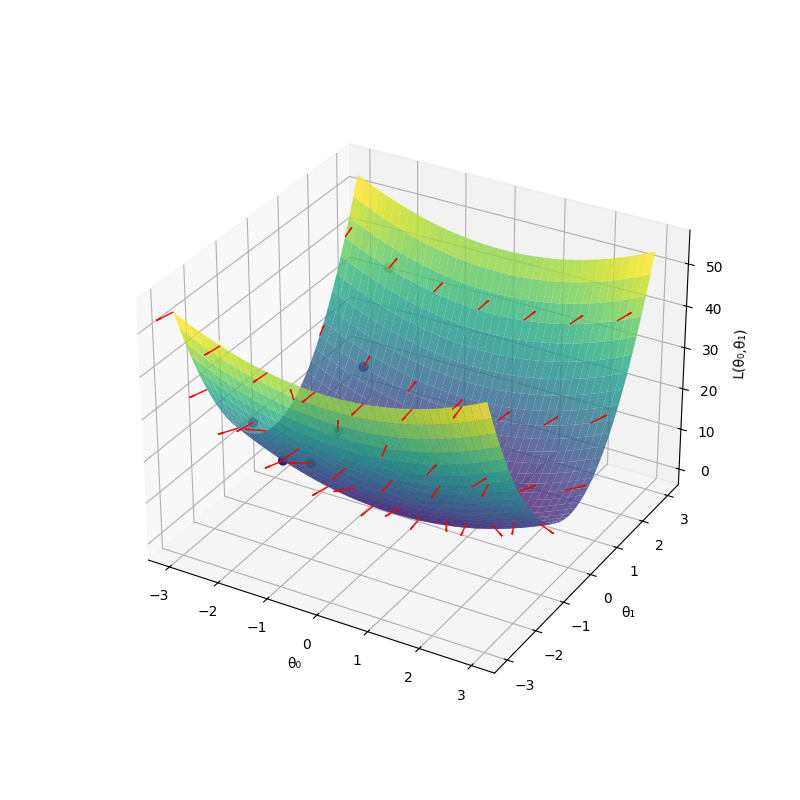

In [2]:

# ----- Enable interactivity -----
plt.ion()

# ----- Grid -----
n = 40
a0 = torch.linspace(-3, 3, n)
a1 = torch.linspace(-3, 3, n)
A0, A1 = torch.meshgrid(a0, a1)
A0.requires_grad = True
A1.requires_grad = True

# ----- Function -----
Z = A0**2 + 5*A1**2

# ----- Gradients -----
Z.sum().backward()
G0 = 2*A0.detach()
G1 = 10*A1.detach()

# ----- Convert -----
A0n = A0.detach().numpy()
A1n = A1.detach().numpy()
Zn = Z.detach().numpy()

# ----- Plot -----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Surface
ax.plot_surface(
    A0n, A1n, Zn,
    cmap="viridis",
    alpha=0.8,
    linewidth=0
)

# Gradient arrows (tangent)
step = 6
ax.quiver(
    A0n[::step, ::step],
    A1n[::step, ::step],
    Zn[::step, ::step],
    G0[::step, ::step],
    G1[::step, ::step],
    np.zeros_like(G0[::step, ::step]),
    color="red",
    length=0.4,
    linewidth=1,
    normalize=True
)


ax.scatter(
    A0n[step, ::step],
    A1n[step, ::step],
    Zn[step, ::step],
    c=Zn[step, ::step],
    s=40,
    alpha=0.9,
    cmap='magma'
)

ax.set_xlabel("θ₀")
ax.set_ylabel("θ₁")
ax.set_zlabel("L(θ₀,θ₁)")

plt.show()


## Ploting vectors using quiver

## 2D arrows

- v = (x0, y0) + (u, v)
- starting point + direction

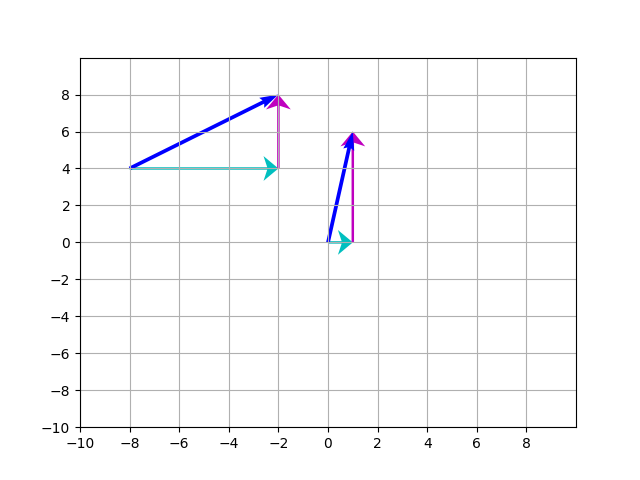

In [60]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection="2d")
plt.figure()
ax = plt.subplot()
xy = torch.tensor([[0, -8], 
                   [0, 4]])

uv = torch.tensor([[1, 6], 
                   [6, 4]])

# plot x components only
ax.quiver(xy[0, :],
          xy[1:, ], # y pos of vector
          uv[0, :], # x component of the ver
          torch.zeros_like(uv[1, :]), # y componet of the vectors
          angles='xy',
          scale_units='xy',
          scale=1,
          color='c',
          width=0.005,
          headwidth=10,
          headlength=6
          )

# plot y components only

ax.quiver(xy[0, :] + uv[0, :], # or xy[0, :]
          xy[1:, ], # y pos of vector
          torch.zeros_like(uv[0, :]), # x component of the ver
          uv[1, :], # y componet of the vectors
          angles='xy',
          scale_units='xy',
          scale=1,
          color='m',
          width=0.005,
          headwidth=10,
          headlength=6
          )

# plot vector
ax.quiver(xy[0, :],
          xy[1:, ], # y pos of vector
          uv[0, :], # x component of the ver
          uv[1, :], # y componet of the vectors
          angles='xy',
          scale_units='xy',
          scale=1,
          color='b',
        #   width=0.5
          )

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xticks(range(-10, 10, 2))
ax.set_yticks(range(-10, 10, 2))

ax.grid()

## 3D arrows

(-10.0, 10.0)

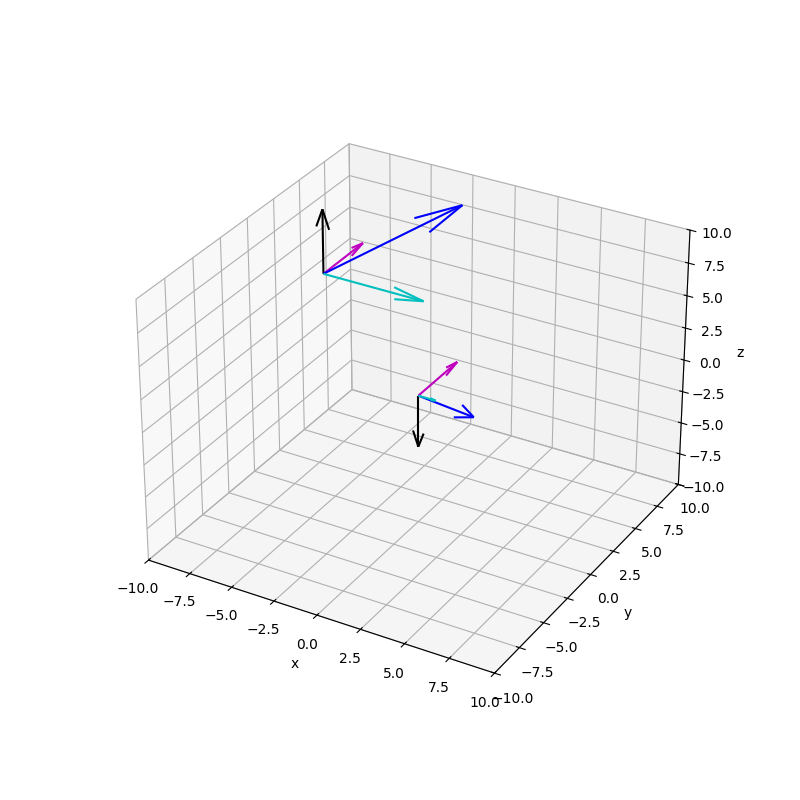

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# ----- Enable interactivity -----
plt.ion()


# ----- Plot -----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")


xyz = torch.tensor([[0, -8], 
                   [0, 4],
                   [0, 4]
                   ]
                   )

uvw = torch.tensor([[1, 6], 
                   [4, 4],
                   [-4, 5],
                   ])

# draw the x component
ax.quiver(
    xyz[0, :],
    xyz[1, :],
    xyz[2, :],
    uvw[0, :],
    torch.zeros_like(uvw[1, :]),
    torch.zeros_like(uvw[2, :]),
    color='c',
    # length=0.4,
    # linewidth=1,
    normalize=False
)
# draw the y componet
ax.quiver(
    xyz[0, :],
    xyz[1, :],
    xyz[2, :],
    torch.zeros_like(uvw[0, :]),
    uvw[1, :],
    torch.zeros_like(uvw[2, :]),
    color='m',
    # length=0.4,
    # linewidth=1,
    normalize=False
)

# draw the z componet
ax.quiver(
    xyz[0, :],
    xyz[1, :],
    xyz[2, :],
    torch.zeros_like(uvw[0, :]),
    torch.zeros_like(uvw[1, :]),
    uvw[2, :],
    color='k',
    # length=0.4,
    # linewidth=1,
    normalize=False
)

# draw the vectors
ax.quiver(
    xyz[0, :],
    xyz[1, :],
    xyz[2, :],
    uvw[0, :],
    uvw[1, :],
    uvw[2, :],
    color='b',
    # length=0.4,
    # linewidth=1,
    normalize=False
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
# ax.grid(False)


